In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load all datasets
train_df = pd.read_csv('/kaggle/input/walmart-sales-forecast/train.csv')
test_df = pd.read_csv('/kaggle/input/walmart-sales-forecast/test.csv')
features_df = pd.read_csv('/kaggle/input/walmart-sales-forecast/features.csv')
stores_df = pd.read_csv('/kaggle/input/walmart-sales-forecast/stores.csv')

In [3]:
print("Dataset shapes:")
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"Features: {features_df.shape}")
print(f"Stores: {stores_df.shape}")

Dataset shapes:
Train: (421570, 5)
Test: (115064, 4)
Features: (8190, 12)
Stores: (45, 3)


In [4]:
print("\nTrain data sample:")
print(train_df.head())

print("\nFeatures data sample:")
print(features_df.head())

print("\nStores data sample:")
print(stores_df.head())


Train data sample:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Features data sample:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       Tru

In [5]:
# Parse dates in all datasets
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

print(f"\nDate ranges:")
print(f"Train: {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"Test: {test_df['Date'].min()} to {test_df['Date'].max()}")
print(f"Features: {features_df['Date'].min()} to {features_df['Date'].max()}")


Date ranges:
Train: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Test: 2012-11-02 00:00:00 to 2013-07-26 00:00:00
Features: 2010-02-05 00:00:00 to 2013-07-26 00:00:00


In [6]:
# Merge train data with features and stores
train_merged = train_df.merge(features_df, on=['Store', 'Date'], how='left')
train_merged = train_merged.merge(stores_df, on='Store', how='left')

# Merge test data with features and stores (for future predictions)
test_merged = test_df.merge(features_df, on=['Store', 'Date'], how='left')
test_merged = test_merged.merge(stores_df, on='Store', how='left')

print(f"Merged train data shape: {train_merged.shape}")
print(f"Merged test data shape: {test_merged.shape}")

# Check for missing values
print("\nMissing values in merged train data:")
print(train_merged.isnull().sum())

Merged train data shape: (421570, 17)
Merged test data shape: (115064, 16)

Missing values in merged train data:
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64


In [7]:
# Fill missing MarkDown values with 0 (assuming no promotion)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    if col in train_merged.columns:
        train_merged[col] = train_merged[col].fillna(0)
        test_merged[col] = test_merged[col].fillna(0)

# Fill other missing values with forward fill then backward fill
train_merged = train_merged.fillna(method='ffill').fillna(method='bfill')
test_merged = test_merged.fillna(method='ffill').fillna(method='bfill')

print(f"\nAfter handling missing values:")
print(f"Train missing values: {train_merged.isnull().sum().sum()}")
print(f"Test missing values: {test_merged.isnull().sum().sum()}")


After handling missing values:
Train missing values: 0
Test missing values: 0


In [8]:
# Aggregate sales by date for time series analysis
daily_sales = train_merged.groupby('Date')['Weekly_Sales'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)

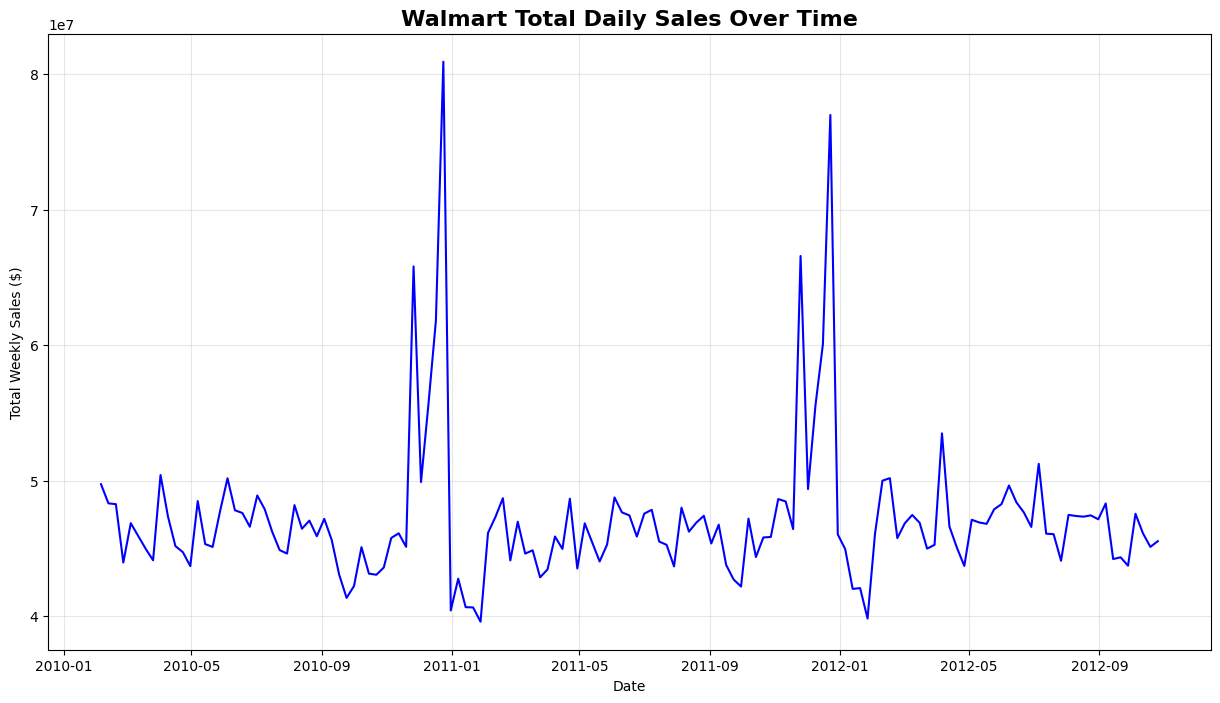

In [9]:
# Time series visualization
plt.figure(figsize=(15, 8))
plt.plot(daily_sales.index, daily_sales['Weekly_Sales'], linewidth=1.5, color='blue')
plt.title('Walmart Total Daily Sales Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales ($)')
plt.grid(True, alpha=0.3)
plt.show()

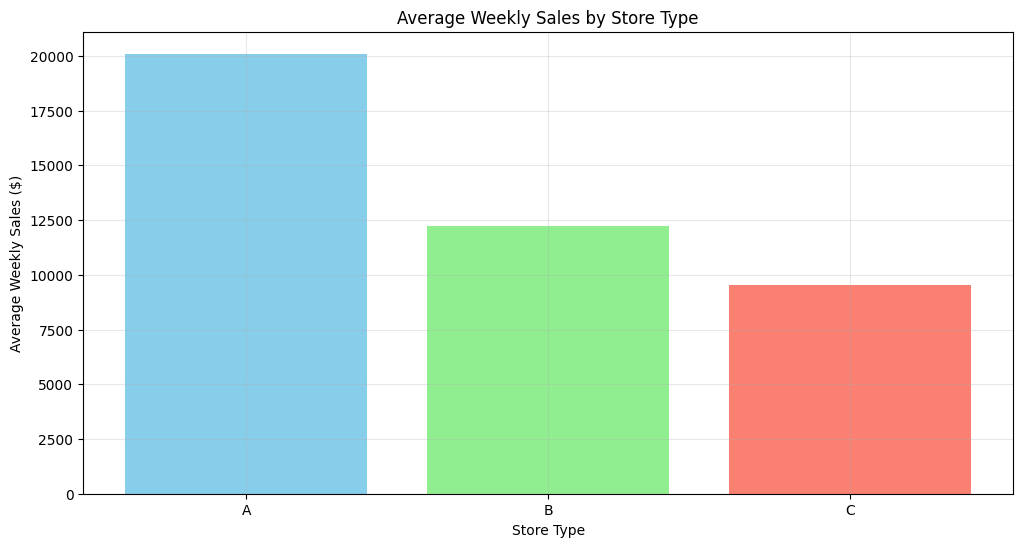

In [10]:
# Sales by store type
plt.figure(figsize=(12, 6))
store_type_sales = train_merged.groupby('Type')['Weekly_Sales'].mean()
plt.bar(store_type_sales.index, store_type_sales.values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Weekly Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Weekly Sales ($)')
plt.grid(True, alpha=0.3)
plt.show()

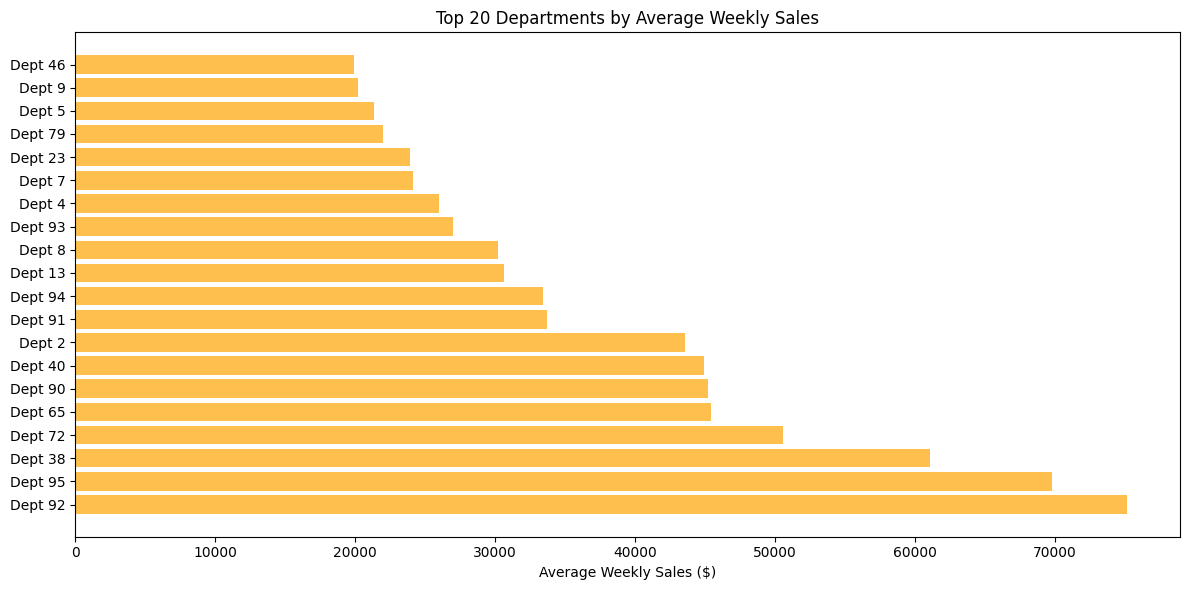

In [11]:
# Sales distribution by department
plt.figure(figsize=(12, 6))
dept_sales = train_merged.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False).head(20)
plt.barh(range(len(dept_sales)), dept_sales.values, color='orange', alpha=0.7)
plt.yticks(range(len(dept_sales)), [f'Dept {int(d)}' for d in dept_sales.index])
plt.title('Top 20 Departments by Average Weekly Sales')
plt.xlabel('Average Weekly Sales ($)')
plt.tight_layout()
plt.show()

In [12]:
# Check if we have IsHoliday_x and IsHoliday_y
if 'IsHoliday_x' in train_merged.columns and 'IsHoliday_y' in train_merged.columns:
    # Use IsHoliday_x (from train data) as the primary holiday indicator
    train_merged['IsHoliday'] = train_merged['IsHoliday_x']
    # Drop the duplicate columns
    train_merged = train_merged.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)

    # Do the same for test data
    if 'IsHoliday_x' in test_merged.columns and 'IsHoliday_y' in test_merged.columns:
        test_merged['IsHoliday'] = test_merged['IsHoliday_x']
        test_merged = test_merged.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)

print(f"\nAfter fixing IsHoliday columns:")
print(f"Train columns: {len(train_merged.columns)}")
print(f"Test columns: {len(test_merged.columns)}")


After fixing IsHoliday columns:
Train columns: 16
Test columns: 15


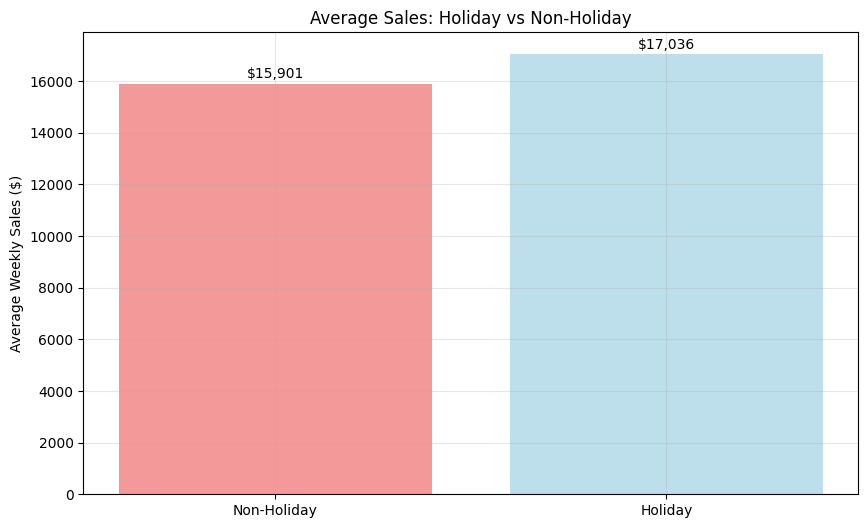

In [13]:
# Holiday vs Non-Holiday sales
plt.figure(figsize=(10, 6))
holiday_sales = train_merged.groupby('IsHoliday')['Weekly_Sales'].mean()
colors = ['lightcoral', 'lightblue']
bars = plt.bar(['Non-Holiday', 'Holiday'], holiday_sales.values, color=colors, alpha=0.8)
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.ylabel('Average Weekly Sales ($)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'${height:,.0f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)
plt.show()

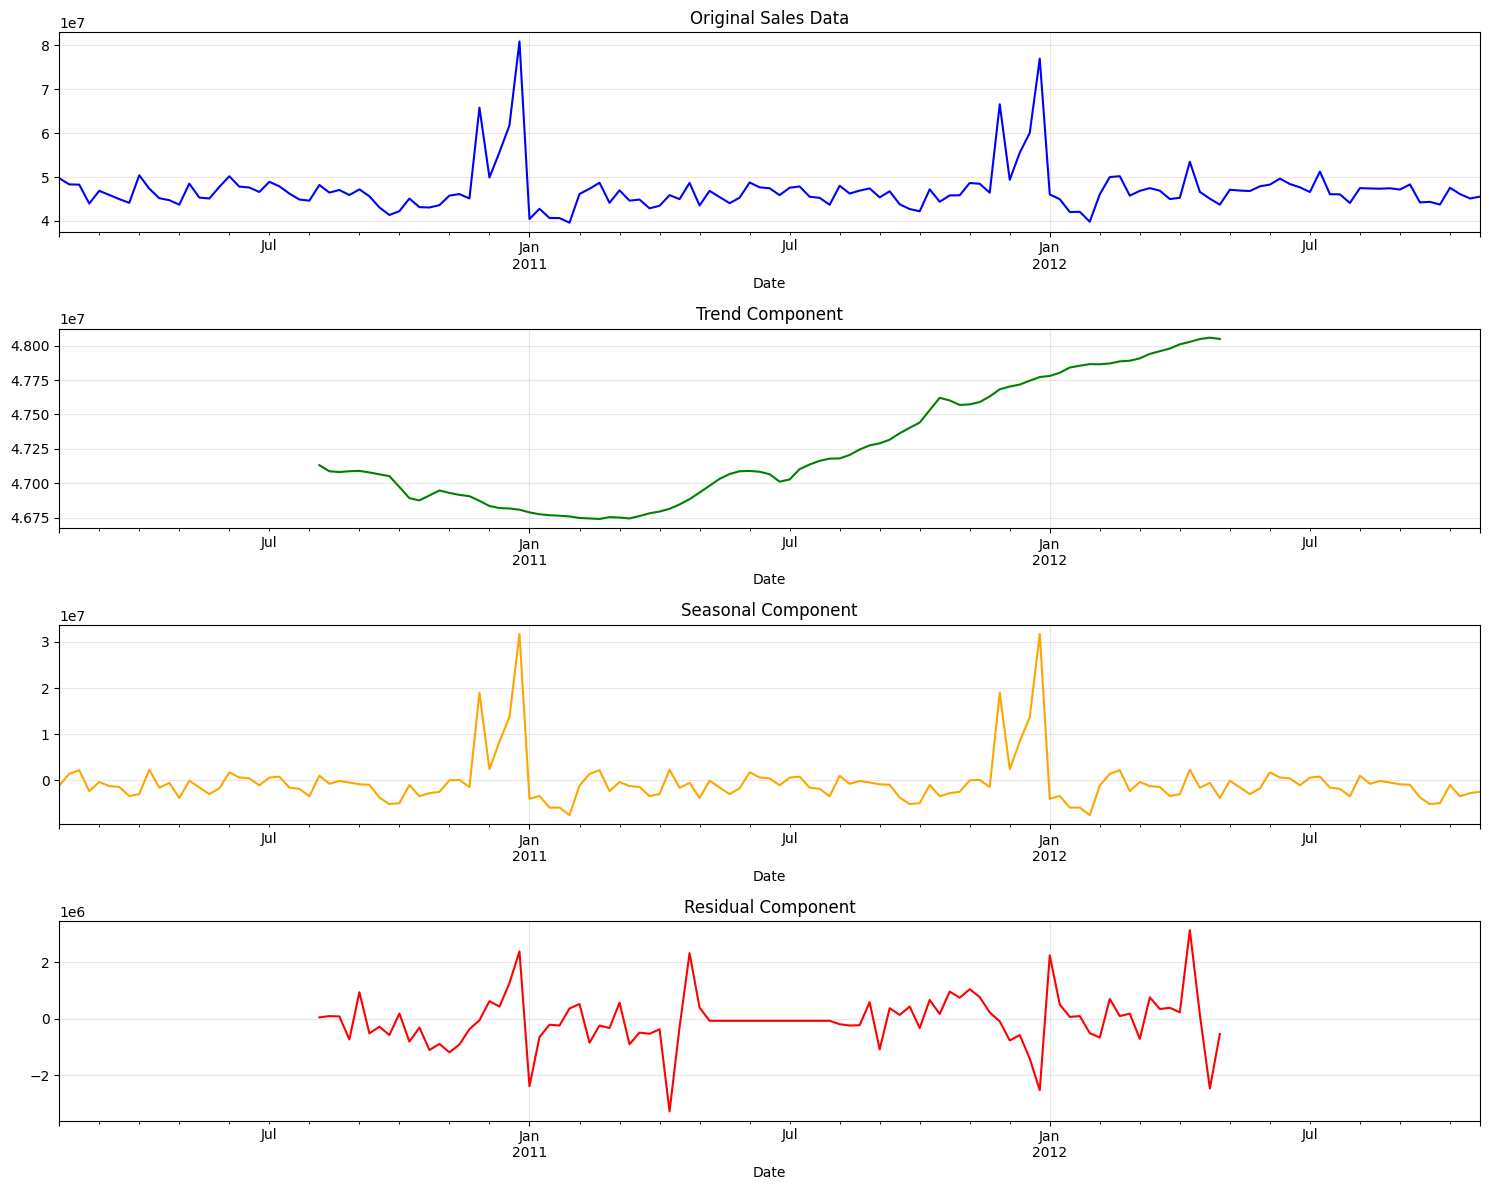

In [14]:
# Seasonal decomposition on aggregated daily sales
decomposition = seasonal_decompose(daily_sales['Weekly_Sales'].resample('W').sum(),
                                 model='additive', period=52)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Original Sales Data', color='blue')
decomposition.trend.plot(ax=axes[1], title='Trend Component', color='green')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', color='orange')
decomposition.resid.plot(ax=axes[3], title='Residual Component', color='red')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
def create_advanced_features(df):
    """Create comprehensive features for the merged dataset"""
    df = df.copy()

    # Ensure Date is in datetime format and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Store', 'Dept', 'Date'])

    # Basic time features
    df['Year'] = df['Date'].dt.year
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
    df['IsYearEnd'] = df['Date'].dt.is_year_end.astype(int)

    # Cyclical features
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
    df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    # Store-Department combination
    df['Store_Dept'] = df['Store'].astype(str) + '_' + df['Dept'].astype(str)

    # Total markdown (promotional intensity)
    markdown_cols = [col for col in df.columns if 'MarkDown' in col]
    if markdown_cols:
        df['Total_MarkDown'] = df[markdown_cols].sum(axis=1)
        df['MarkDown_Count'] = (df[markdown_cols] > 0).sum(axis=1)

    # Lag features (if Weekly_Sales exists)
    if 'Weekly_Sales' in df.columns:
        # Sort by Store, Dept, Date for proper lag calculation
        df = df.sort_values(['Store', 'Dept', 'Date'])

        # Create lag features by Store-Dept combination
        for lag in [1, 2, 4, 8, 12]:
            df[f'Sales_lag_{lag}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

        # Rolling statistics by Store-Dept
        for window in [4, 8, 12]:
            df[f'Sales_rolling_mean_{window}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean())
            df[f'Sales_rolling_std_{window}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
                lambda x: x.rolling(window=window, min_periods=1).std())

    return df

In [16]:
# Apply feature engineering
train_features = create_advanced_features(train_merged)
test_features = create_advanced_features(test_merged)

print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: (421570, 44)
Test features shape: (115064, 32)


In [17]:
# Combine train and test for creating lag features
combined_data = pd.concat([train_features, test_features], sort=False).sort_values(['Store', 'Dept', 'Date'])

# Create lag features for the combined dataset
for lag in [1, 2, 4, 8, 12]:
    combined_data[f'Sales_lag_{lag}'] = combined_data.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

# Rolling statistics for combined dataset
for window in [4, 8, 12]:
    combined_data[f'Sales_rolling_mean_{window}'] = combined_data.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean())
    combined_data[f'Sales_rolling_std_{window}'] = combined_data.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std())

In [18]:
# Split back to train and test
train_indices = len(train_features)
train_features_with_lags = combined_data[:train_indices].copy()
test_features_with_lags = combined_data[train_indices:].copy()

print(f"Train features with lags shape: {train_features_with_lags.shape}")
print(f"Test features with lags shape: {test_features_with_lags.shape}")

# Use the datasets with lag features
train_features = train_features_with_lags
test_features = test_features_with_lags

categorical_cols = ['Type', 'Store_Dept']
label_encoders = {}

for col in categorical_cols:
    if col in train_features.columns:
        le = LabelEncoder()
        # Fit on combined data to ensure consistent encoding
        combined_values = pd.concat([train_features[col], test_features[col]]).astype(str)
        le.fit(combined_values)

        train_features[col + '_encoded'] = le.transform(train_features[col].astype(str))
        test_features[col + '_encoded'] = le.transform(test_features[col].astype(str))
        label_encoders[col] = le

Train features with lags shape: (421570, 44)
Test features with lags shape: (115064, 44)


In [19]:
# Remove rows with NaN values (due to lag features)
train_clean = train_features.dropna()
print(f"Training data after removing NaN: {train_clean.shape}")

# Now we can use all features since both datasets have them
exclude_cols = ['Date', 'Store_Dept', 'Type', 'Weekly_Sales']
feature_cols = [col for col in train_clean.columns if col not in exclude_cols]

print(f"Total features used: {len(feature_cols)}")

X = train_clean[feature_cols]
y = train_clean['Weekly_Sales']

# Time-aware split (80-20)
split_date = train_clean['Date'].quantile(0.8)
train_mask = train_clean['Date'] <= split_date
test_mask = train_clean['Date'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Training data: {X_train.shape}")
print(f"Testing data: {X_test.shape}")
print(f"Split date: {split_date}")

print(f"\nFeatures being used: {len(feature_cols)}")
print("Feature columns:", feature_cols[:10], "..." if len(feature_cols) > 10 else "")

Training data after removing NaN: (301293, 46)
Total features used: 42
Training data: (241197, 42)
Testing data: (60096, 42)
Split date: 2012-04-27 00:00:00

Features being used: 42
Feature columns: ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI'] ...


In [20]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Evaluate Linear Regression
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression Results:")
print(f"MAE: ${lr_mae:,.2f}")
print(f"RMSE: ${lr_rmse:,.2f}")
print(f"R²: {lr_r2:.4f}")

Linear Regression Results:
MAE: $1,139.34
RMSE: $2,183.75
R²: 0.9908


In [21]:
# Random Forest Hyperparameter Tuning
rf_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
                               param_distributions=rf_params,
                               n_iter=20,
                               cv=3,
                               scoring='r2',
                               random_state=42,
                               n_jobs=-1,
                               verbose=1)

rf_search.fit(X_train, y_train)
best_rf_model = rf_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [22]:
# Predict with optimized Random Forest
rf_pred = best_rf_model.predict(X_test)

# Evaluate Random Forest
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest Results:")
print(f"MAE: ${rf_mae:,.2f}")
print(f"RMSE: ${rf_rmse:,.2f}")
print(f"R²: {rf_r2:.4f}")

Random Forest Results:
MAE: $1,122.53
RMSE: $2,276.42
R²: 0.9900


In [23]:
# XGBoost Hyperparameter Tuning
xgb_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(XGBRegressor(random_state=42, n_jobs=-1),
                                param_distributions=xgb_params,
                                n_iter=20,
                                cv=3,
                                scoring='r2',
                                random_state=42,
                                n_jobs=-1,
                                verbose=1)

xgb_search.fit(X_train, y_train)
best_xgb_model = xgb_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [24]:
# Predict with optimized XGBoost
xgb_pred = best_xgb_model.predict(X_test)

# Evaluate XGBoost
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"XGBoost Results:")
print(f"MAE: ${xgb_mae:,.2f}")
print(f"RMSE: ${xgb_rmse:,.2f}")
print(f"R²: {xgb_r2:.4f}")

XGBoost Results:
MAE: $969.56
RMSE: $2,007.92
R²: 0.9922


In [25]:
# LightGBM Hyperparameter Tuning
lgb_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.19),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'num_leaves': randint(20, 100)
}

lgb_search = RandomizedSearchCV(LGBMRegressor(random_state=42, verbose=-1, n_jobs=-1),
                                param_distributions=lgb_params,
                                n_iter=20,
                                cv=3,
                                scoring='r2',
                                random_state=42,
                                n_jobs=-1,
                                verbose=1)

lgb_search.fit(X_train, y_train)
best_lgb_model = lgb_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [26]:
# Predict with optimized LightGBM
lgb_pred = best_lgb_model.predict(X_test)

# Evaluate LightGBM
lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)

print(f"LightGBM Results:")
print(f"MAE: ${lgb_mae:,.2f}")
print(f"RMSE: ${lgb_rmse:,.2f}")
print(f"R²: {lgb_r2:.4f}")

LightGBM Results:
MAE: $956.42
RMSE: $2,009.75
R²: 0.9922


In [27]:
# Model Performance Comparison
print("Model Performance Comparison:")
print(f"Linear Regression R²: {lr_r2:.4f}")
print(f"Random Forest R²: {rf_r2:.4f}")
print(f"XGBoost R²: {xgb_r2:.4f}")
print(f"LightGBM R²: {lgb_r2:.4f}")

# Determine best model
models = {
    'Linear Regression': (lr_model, lr_pred, lr_r2),
    'Random Forest': (best_rf_model, rf_pred, rf_r2),
    'XGBoost': (best_xgb_model, xgb_pred, xgb_r2),
    'LightGBM': (best_lgb_model, lgb_pred, lgb_r2)
}

best_model_name = max(models.keys(), key=lambda x: models[x][2])
best_model, best_pred, best_r2 = models[best_model_name]

print(f"\nBest Model: {best_model_name} (R² = {best_r2:.4f})")

Model Performance Comparison:
Linear Regression R²: 0.9908
Random Forest R²: 0.9900
XGBoost R²: 0.9922
LightGBM R²: 0.9922

Best Model: XGBoost (R² = 0.9922)


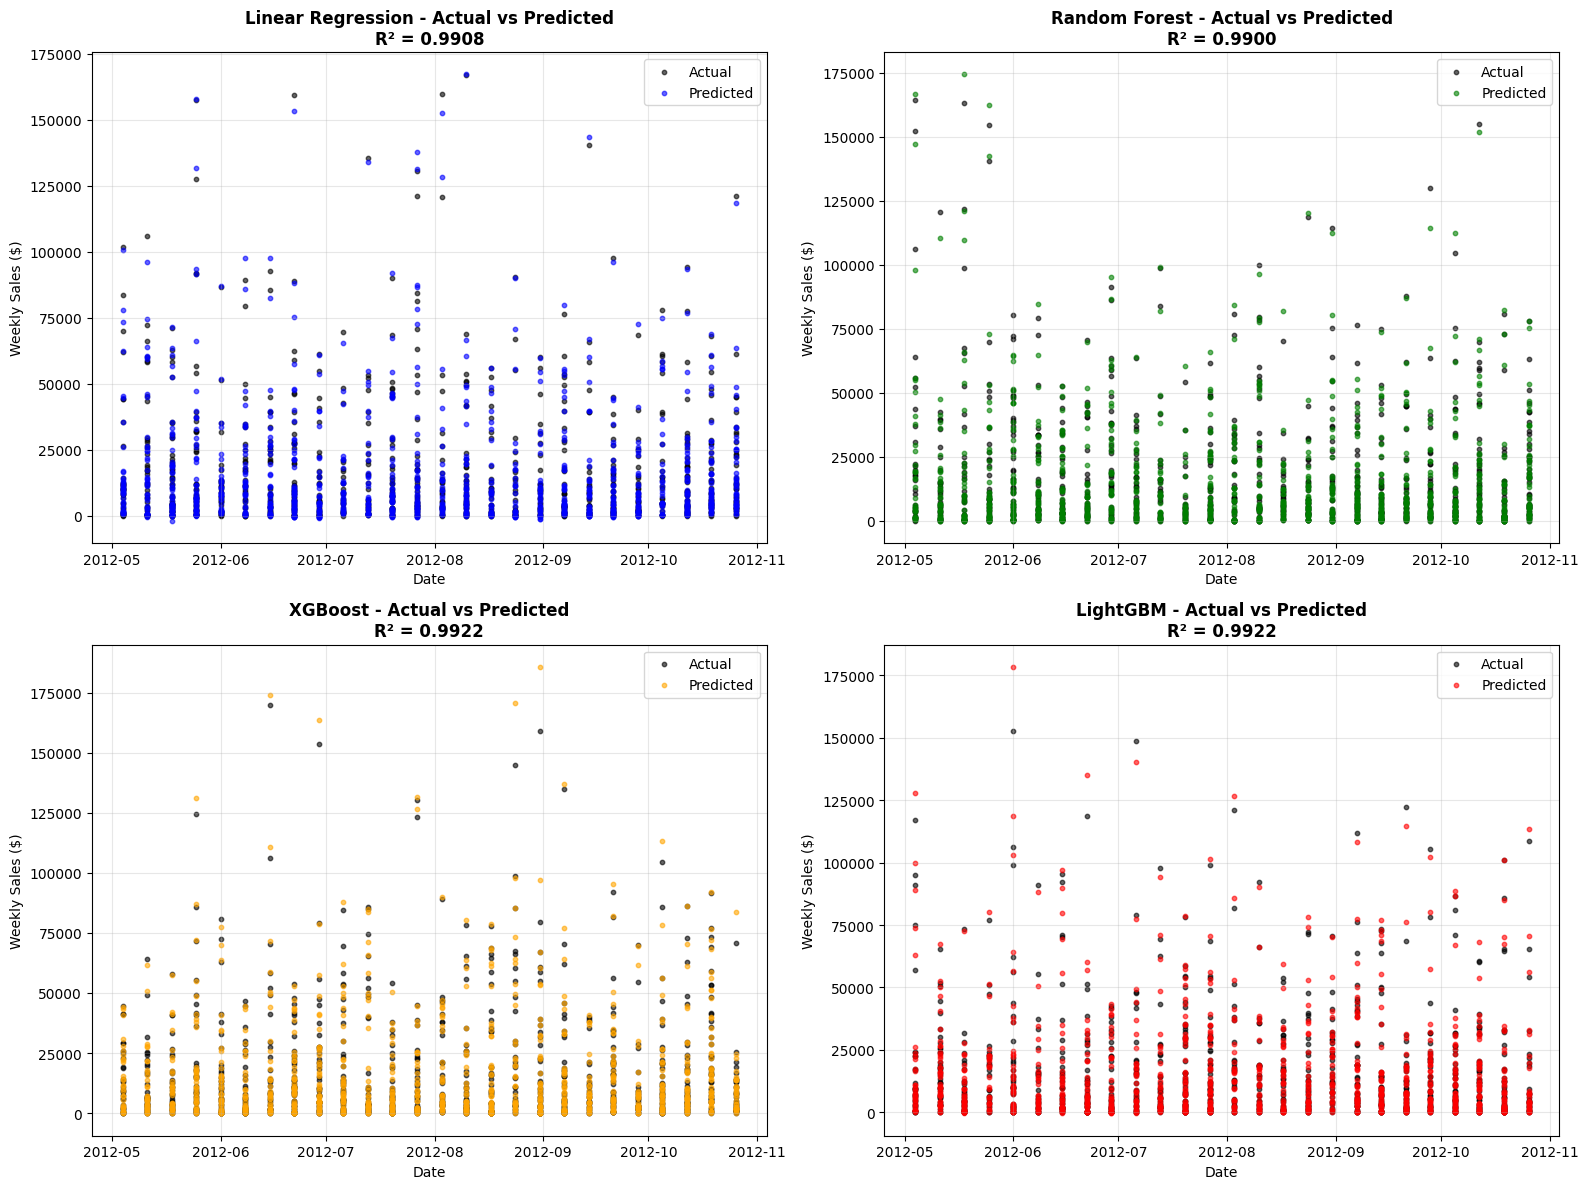

In [28]:
# Plot actual vs predicted for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Get test dates for plotting
test_dates = train_clean[test_mask]['Date'].values
model_names = ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM']
predictions = [lr_pred, rf_pred, xgb_pred, lgb_pred]
colors = ['blue', 'green', 'orange', 'red']

for i, (name, pred, color) in enumerate(zip(model_names, predictions, colors)):
    ax = axes[i]

    # Sample data points for better visualization (if too many points)
    if len(test_dates) > 1000:
        sample_idx = np.random.choice(len(test_dates), 1000, replace=False)
        sample_dates = test_dates[sample_idx]
        sample_actual = y_test.values[sample_idx]
        sample_pred = pred[sample_idx]
    else:
        sample_dates = test_dates
        sample_actual = y_test.values
        sample_pred = pred

    ax.scatter(sample_dates, sample_actual, label='Actual', alpha=0.6, color='black', s=10)
    ax.scatter(sample_dates, sample_pred, label='Predicted', alpha=0.6, color=color, s=10)

    r2_score_val = models[name][2]
    ax.set_title(f'{name} - Actual vs Predicted\nR² = {r2_score_val:.4f}', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

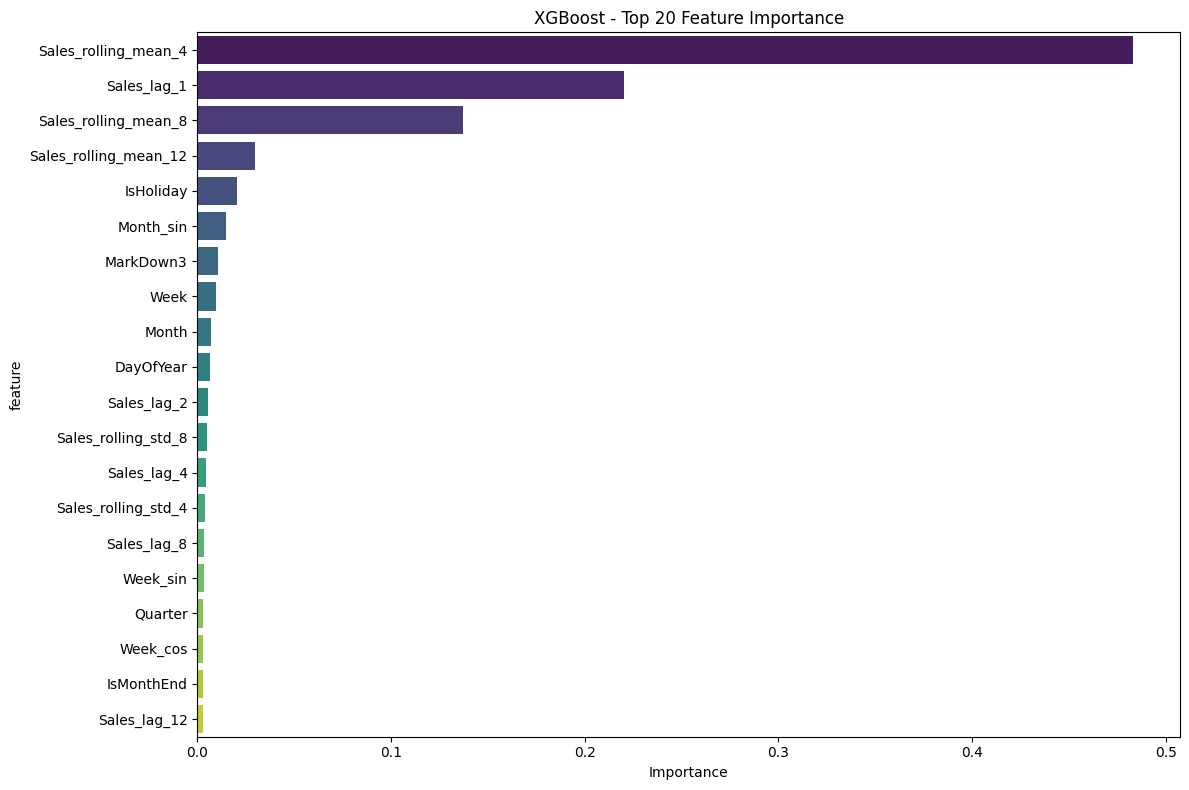


Top 15 Most Important Features (XGBoost):
                  feature  importance
34   Sales_rolling_mean_4      0.4833
29            Sales_lag_1      0.2202
36   Sales_rolling_mean_8      0.1370
38  Sales_rolling_mean_12      0.0295
12              IsHoliday      0.0205
21              Month_sin      0.0148
6               MarkDown3      0.0107
16                   Week      0.0097
15                  Month      0.0069
17              DayOfYear      0.0068
30            Sales_lag_2      0.0056
37    Sales_rolling_std_8      0.0050
31            Sales_lag_4      0.0045
35    Sales_rolling_std_4      0.0039
32            Sales_lag_8      0.0034


In [29]:
# Feature importance from best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(20), x='importance', y='feature', palette='viridis')
    plt.title(f'{best_model_name} - Top 20 Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print(f"\nTop 15 Most Important Features ({best_model_name}):")
    print(feature_importance.head(15).round(4))

In [30]:
# Prepare test data for predictions - remove NaN rows for test predictions
test_clean = test_features.dropna()
X_future = test_clean[feature_cols]

# Make predictions using the best model
future_predictions = best_model.predict(X_future)

# Create submission dataframe
submission = pd.DataFrame({
    'Store': test_clean['Store'],
    'Dept': test_clean['Dept'],
    'Date': test_clean['Date'],
    'Weekly_Sales': future_predictions
})

print(f"Future predictions shape: {submission.shape}")
print("\nSample predictions:")
print(submission.head(10))

Future predictions shape: (81662, 4)

Sample predictions:
        Store  Dept       Date  Weekly_Sales
331362     35     5 2010-09-10  17879.654297
331363     35     5 2010-09-17  17755.630859
331364     35     5 2010-09-24  20033.570312
331365     35     5 2010-10-01  18271.359375
331366     35     5 2010-10-08  24829.642578
331367     35     5 2010-10-15  20443.609375
331368     35     5 2010-10-22  20814.552734
331369     35     5 2010-10-29  21519.593750
331370     35     5 2010-11-05  20888.095703
331371     35     5 2010-11-12  26277.466797


In [31]:
# Save predictions
submission.to_csv('walmart_sales_predictions.csv', index=False)

In [32]:
print("\n" + "="*60)
print("WALMART SALES FORECASTING - FINAL RESULTS")
print("="*60)
print("✓ Multi-file dataset successfully merged and processed")
print("✓ Advanced feature engineering with store/dept specifics")
print("✓ MarkDown features included (promotional impact)")
print("✓ External factors integrated (Temperature, Fuel_Price, CPI)")
print("✓ Multiple regression models trained and optimized")
print(f"✓ Best performing model: {best_model_name} (R² = {best_r2:.4f})")
print("✓ Future predictions generated for test set")
print("✓ Time-aware validation and proper data splitting")
print("="*60)


WALMART SALES FORECASTING - FINAL RESULTS
✓ Multi-file dataset successfully merged and processed
✓ Advanced feature engineering with store/dept specifics
✓ MarkDown features included (promotional impact)
✓ External factors integrated (Temperature, Fuel_Price, CPI)
✓ Multiple regression models trained and optimized
✓ Best performing model: XGBoost (R² = 0.9922)
✓ Future predictions generated for test set
✓ Time-aware validation and proper data splitting
